We run the MNIST example from Liu et al; adapted for output scaling.

In [1]:
from collections import defaultdict
from itertools import islice
import random
import time
import os
from pathlib import Path
import math

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
optimizer_dict = {
    'AdamW': torch.optim.AdamW,
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

activation_dict = {
    'ReLU': nn.ReLU,
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid,
    'GELU': nn.GELU
}

loss_function_dict = {
    'MSE': nn.MSELoss,
    'CrossEntropy': nn.CrossEntropyLoss
}

In [24]:
train_points = 1000
optimization_steps = 100001
batch_size = 200
loss_function = 'MSE'   # 'MSE' or 'CrossEntropy'
optimizer = 'AdamW'     # 'AdamW' or 'Adam' or 'SGD'
lr = 1e-3
initialization_scale = 8.0
download_directory = "../data"
weight_decay = 0
depth = 3              # the number of nn.Linear modules in the model
width = 200
activation = 'ReLU'     # 'ReLU' or 'Tanh' or 'Sigmoid' or 'GELU'

log_freq = math.ceil(optimization_steps / 150)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [25]:
activation_fn = activation_dict[activation]

def create_mlp(depth, width, activation, alpha=1.0):
    """Creates an MLP model with specified depth, width, activation, and output scaling."""
    layers = [nn.Flatten()]
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(28 * 28, width))
            layers.append(activation_fn())
        elif i == depth - 1:
            layers.append(nn.Linear(width, 10))
        else:
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())

    class OutputScaledMLP(nn.Module):
        def __init__(self, mlp, alpha):
            super().__init__()
            self.mlp = mlp
            self.alpha = alpha

        def forward(self, x):
            return self.alpha * self.mlp(x)

    return OutputScaledMLP(nn.Sequential(*layers), alpha).to(device)

In [26]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    """Computes accuracy of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, dataset, loss_function, device, N=2000, batch_size=50):
    """Computes mean loss of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss_fn = loss_function_dict[loss_function](reduction='sum')
        one_hots = torch.eye(10, 10).to(device)
        total = 0
        points = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            y = network(x.to(device))
            if loss_function == 'CrossEntropy':
                total += loss_fn(y, labels.to(device)).item()
            elif loss_function == 'MSE':
                total += loss_fn(y, one_hots[labels]).item()
            points += len(labels)
        return total / points

In [27]:
# load dataset
train = torchvision.datasets.MNIST(root=download_directory, train=True,
    transform=torchvision.transforms.ToTensor(), download=False)
test = torchvision.datasets.MNIST(root=download_directory, train=False,
    transform=torchvision.transforms.ToTensor(), download=False)
train = torch.utils.data.Subset(train, range(train_points))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

assert activation in activation_dict, f"Unsupported activation function: {activation}"
activation_fn = activation_dict[activation]

In [68]:
subset_indices = np.random.choice(len(test), 1000, replace=False) 
test_subset = torch.utils.data.Subset(test, subset_indices)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=100, shuffle=False)

In [28]:
# alphas = [0.001, 0.01, 0.05, 0.5]
# alphas = [0.001, 0.5]
alphas = [0.5]

results = {}
for alpha in alphas:

    print(f"alpha: {alpha}")
    # Create model
    mlp = create_mlp(depth, width, activation_fn, alpha)

    with torch.no_grad():
        for p in mlp.parameters():
            p.data = initialization_scale * p.data

    # create optimizer
    assert optimizer in optimizer_dict, f"Unsupported optimizer choice: {optimizer}"
    optimizer = optimizer_dict[optimizer](mlp.parameters(), lr=lr, weight_decay=weight_decay)

    # define loss function
    assert loss_function in loss_function_dict
    loss_fn = loss_function_dict[loss_function]()


    results[alpha] = {'train_loss': [], 'test_loss': [],
                        'train_accuracies': [], 'test_accuracies':[],
                        'log_steps':[],
                        'norms':[], 'last_layer_norms':[]}


    steps = 0
    one_hots = torch.eye(10, 10).to(device)

    with tqdm(total=optimization_steps) as pbar:
        for x, labels in islice(cycle(train_loader), optimization_steps):
            if (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0:
                results[alpha]['train_loss'].append(compute_loss(mlp, train, loss_function, device, N=len(train)))
                results[alpha]['train_accuracies'].append(compute_accuracy(mlp, train, device, N=len(train)))
                results[alpha]['test_loss'].append(compute_loss(mlp, test, loss_function, device, N=len(test)))
                results[alpha]['test_accuracies'].append(compute_accuracy(mlp, test, device, N=len(test)))
                results[alpha]['log_steps'].append(steps)
                with torch.no_grad():
                    total = sum(torch.pow(p, 2).sum() for p in mlp.parameters())
                    results[alpha]['norms'].append(float(np.sqrt(total.item())))
                    last_layer = sum(torch.pow(p, 2).sum() for p in mlp.mlp[-1].parameters())
                    results[alpha]['last_layer_norms'].append(float(np.sqrt(last_layer.item())))
                pbar.set_description("L: {0:1.1e}|{1:1.1e}. A: {2:2.1f}%|{3:2.1f}%".format(
                    results[alpha]['train_loss'][-1],
                    results[alpha]['test_loss'][-1],
                    results[alpha]['train_accuracies'][-1] * 100,
                    results[alpha]['test_accuracies'][-1] * 100))
                
            if steps in [1, 10, 100, 1000, 10000, 20000, 30000, 40000, 60000, 70000, 80000, 90000, 100000]:
                print(f"steps: {steps}; save model")
                save_path = os.path.join('/data/cici/Geometry/new/MNIST/checkpoints', f'alpha_{alpha}_{steps}.pth')
                torch.save(mlp.state_dict(), save_path)

            optimizer.zero_grad()
            y = mlp(x.to(device))
            if loss_function == 'CrossEntropy':
                loss = loss_fn(y, labels.to(device))
            elif loss_function == 'MSE':
                loss = loss_fn(y, one_hots[labels])
            loss.backward()
            optimizer.step()
            steps += 1
            pbar.update(1)


alpha: 0.5


  0%|          | 0/100001 [00:00<?, ?it/s]

steps: 1; save model
steps: 10; save model
steps: 100; save model
steps: 1000; save model
steps: 10000; save model
steps: 20000; save model
steps: 30000; save model
steps: 40000; save model
steps: 60000; save model
steps: 70000; save model
steps: 80000; save model
steps: 90000; save model
steps: 100000; save model


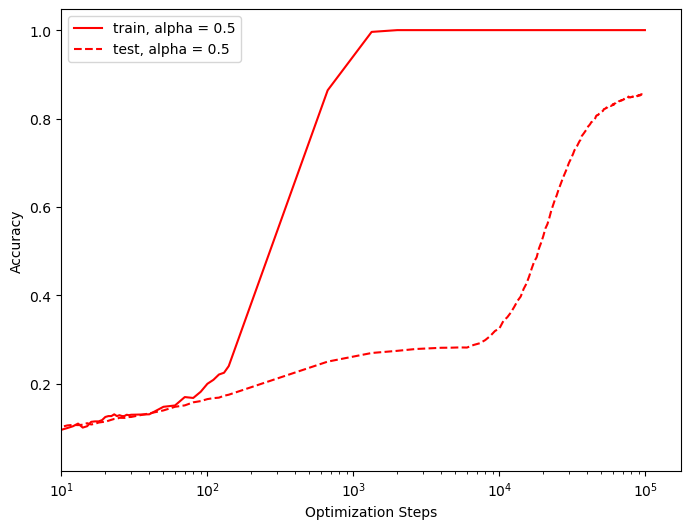

In [33]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(results[alphas[0]]['log_steps'], results[alphas[0]]['train_accuracies'], color='red', label=f'train, alpha = {alphas[0]}')
plt.plot(results[alphas[0]]['log_steps'], results[alphas[0]]['test_accuracies'], color='red', ls = '--', label=f'test, alpha = {alphas[0]}')
plt.xscale('log')
plt.xlim(10, None)
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.legend(loc= "upper left")
plt.show()

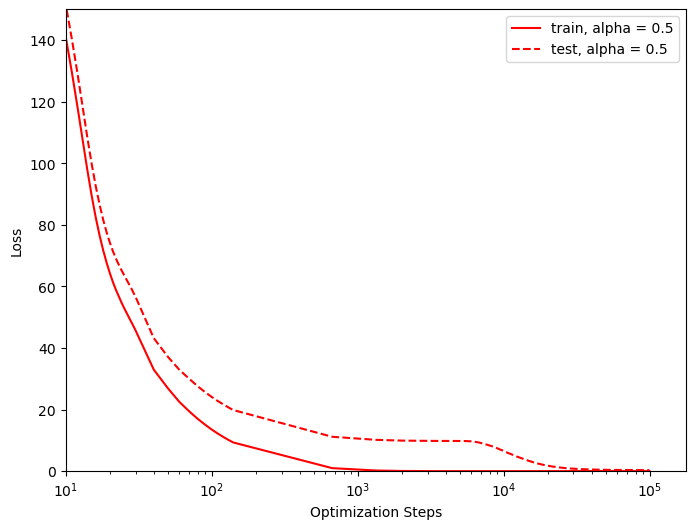

In [34]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(results[alphas[0]]['log_steps'], results[alphas[0]]['train_loss'], color='red', label=f'train, alpha = {alphas[0]}')
plt.plot(results[alphas[0]]['log_steps'], results[alphas[0]]['test_loss'], color='red', ls = '--', label=f'test, alpha = {alphas[0]}')
plt.xscale('log')
plt.xlim(10, None)
plt.ylim(0, 150)
plt.xlabel("Optimization Steps")
plt.ylabel("Loss")
plt.legend(loc= "upper right")
plt.show()

In [60]:
MLPmodels = []
mlp0 = create_mlp(depth, width, activation_fn, .5)
with torch.no_grad():
    for p in mlp0.parameters():
        p.data = initialization_scale * p.data

MLPmodels.append(mlp0)
for steps in [1, 10, 100, 1000, 10000, 20000, 30000, 40000, 60000, 70000, 80000, 90000, 100000]:
    checkpoint = torch.load(os.path.join('/data/cici/Geometry/new/MNIST/checkpoints', f'alpha_{alpha}_{steps}.pth'))
    mlp = create_mlp(depth, width, activation_fn, .5)
    mlp.load_state_dict(checkpoint)
    MLPmodels.append(mlp)

In [65]:
def compute_ntk_at_epoch(model, dataloader):
    # Set requires_grad to True for all model parameters
    for param in model.parameters():
        param.requires_grad = True
    
    ntk_sum = None
    num_batches = 0
    
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        
        # Compute the Jacobian matrix
        model.zero_grad()
        outputs = model(inputs)
        jacobian = []
        
        for output in outputs:
            grad_output = torch.zeros_like(output)
            grad_output[:] = 1.0
            gradients = torch.autograd.grad(output, model.parameters(), grad_outputs=grad_output, create_graph=True)
            jacobian.append(torch.cat([g.view(-1) for g in gradients]))
        
        jacobian = torch.stack(jacobian)
        
        # Compute the NTK for the current batch
        ntk_batch = torch.matmul(jacobian, jacobian.t())
        
        # Accumulate the NTK sum
        if ntk_sum is None:
            ntk_sum = ntk_batch.cpu().detach()
        else:
            ntk_sum += ntk_batch.cpu().detach()
        
        num_batches += 1
    
    # Compute the average NTK over all batches
    ntk_avg = ntk_sum / num_batches
    
    return ntk_avg.numpy()

def kernel_distance(Kt1, Kt2):
    """
    Compute the kernel distance between two Neural Tangent Kernels.
    
    Args:
        Kt1: NTK matrix at time t1
        Kt2: NTK matrix at time t2
    
    Returns:
        The kernel distance between Kt1 and Kt2
    """
    # Compute the Frobenius inner product
    frobenius_inner_product = np.sum(Kt1 * Kt2)
    
    # Compute the Frobenius norms
    frobenius_norm_Kt1 = np.sqrt(np.sum(Kt1**2))
    frobenius_norm_Kt2 = np.sqrt(np.sum(Kt2**2))
    
    # Compute the kernel distance
    kernel_dist = 1 - frobenius_inner_product / (frobenius_norm_Kt1 * frobenius_norm_Kt2)
    
    return kernel_dist


def compute_pairwise_distances(models, dataloader):
    n = len(models)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            ntk_i = compute_ntk_at_epoch(models[i], dataloader)
            ntk_j = compute_ntk_at_epoch(models[j], dataloader)
            distance = kernel_distance(ntk_i, ntk_j)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    
    return distance_matrix

def plot_heatmap(distance_matrix, param_list, save_path):
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=False, cmap='viridis')
    plt.title(f'Kernel Distance Heatmap for {param_list}')
    plt.xlabel('Model Checkpoint')
    plt.ylabel('Model Checkpoint')
    plt.savefig(save_path)
    plt.close()

In [69]:
distance_matrix = compute_pairwise_distances(MLPmodels, test_loader)

In [70]:
plot_heatmap(distance_matrix, 'MNIST grok','./K-dist.pdf')

In [2]:
from neuronet.utils import models

ModuleNotFoundError: No module named 'neuronet'